In [1]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset, TensorDataset
from torchvision import datasets, transforms
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#training parameters
nb_experiments = 3
nb_epochs_per_acquisition = 100
batch_size = 30
eval_batch_size=256
validation_set_size = 100
dropout_samples = 100
acquisition_iters = 100
points_acquire = 10

#model parameters
nb_filters = 32
nb_classes = 10
filter_size = 4
pool_size = 2
dense_size = 128
dropout_prob_1 = 0.25
dropout_prob_2 = 0.5

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#define our model:
class BayesianCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, nb_filters, kernel_size=filter_size, padding=0)
    self.conv2 = nn.Conv2d(nb_filters, nb_filters, kernel_size=filter_size, padding=0)
    self.pool = nn.MaxPool2d(kernel_size=pool_size)
    self.dropout1 = nn.Dropout(p=dropout_prob_1)

    self.full1 = nn.Linear(32 * 11 * 11, dense_size)
    self.dropout2 = nn.Dropout(p=dropout_prob_2)
    self.ln1 = nn.LayerNorm(dense_size)
    self.full2 = nn.Linear(dense_size, nb_classes)

  def features(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    #x = self.dropout1(x)
    x = F.relu(self.full1(x))
    #x = self.dropout2(x)
    x = self.ln1(x)
    return x

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = self.pool(x)
    x = torch.flatten(x, 1)
    x = self.dropout1(x)
    x = F.relu(self.full1(x))
    x = self.dropout2(x)
    x = self.ln1(x)
    x = self.full2(x)
    return x

  def frozeninf(self, x, post_mu):
    x = self.features(x)
    if x.dim() == 1:
      x = x.unsqueeze(0)
    x = x @ post_mu
    return x

In [4]:
@torch.no_grad()
def eval_model_per_point(model, X_test, y_test, device):
  model = model.to(device)
  model.eval()

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  out = model(X_test)
  y_onehot = F.one_hot(y_test, num_classes=10).float()
  err = ((out - y_onehot) ** 2).sum(dim=1)

  return err.detach().cpu().tolist()


@torch.no_grad()
def eval_model(model, X_test, y_test, device):
  model = model.to(device)
  model.eval()

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  out = model(X_test)
  y_onehot = torch.nn.functional.one_hot(y_test, num_classes=10).float()
  sse = torch.sum((out - y_onehot) ** 2)
  total = y_onehot.numel()

  return (sse / total).sqrt().item()


@torch.no_grad()
def eval_model_frozen_inf(model, X_test, y_test, device, post_mu):
  model = model.to(device)
  model.eval()

  X_test = X_test.to(device)
  y_test = y_test.to(device)

  out = model.frozeninf(X_test, post_mu)
  y_onehot = torch.nn.functional.one_hot(y_test, num_classes=10).float()
  sse = torch.sum((out - y_onehot) ** 2)
  total = y_onehot.numel()

  return (sse / total).sqrt().item()

def train_model(model, X, y, X_val, y_val, optimizer, criterion, batch_size, device, nb_epochs):
  model.train()
  model.to(device)

  dloader = DataLoader(list(zip(X,y)), shuffle=True, batch_size=batch_size)
  patience = 10
  best_val_rmse = 10000
  bad_epochs = 0
  best_state = None

  for epoch in range(nb_epochs):
    model.train()
    train_sse = 0.0
    train_total = 0
    for x, y in dloader:
      x = x.to(device)
      y_onehot = torch.nn.functional.one_hot(y, num_classes=10).float()
      y_onehot = y_onehot.to(device)

      optimizer.zero_grad()
      output = model(x)
      mse = criterion(output, y_onehot)
      mse.backward()
      optimizer.step()

      train_sse += torch.sum((output.detach() - y_onehot) ** 2).item()
      train_total += y_onehot.numel()

    verbose = False

    if verbose:
     train_rmse = (train_sse / train_total) ** 0.5
     print(f"Train rmse {train_rmse}")

    #this was adopted from classification
    #so we need to change the criteria
    early_stopping = True
    if early_stopping:
      val_rmse = eval_model(model, X_val, y_val, device)
      model.train()
      if verbose:
        print(f"Epoch {epoch+1}: val rmse: {val_rmse}")

      if val_rmse <  best_val_rmse:
        best_val_rmse = val_rmse
        bad_epochs = 0
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
      else:
        bad_epochs += 1
        if bad_epochs >= patience:
          print(f"Early stopping at epoch {epoch+1}")
          break

  if best_state is not None:
    model.load_state_dict(best_state)
    model.to(device)


  return model

In [5]:
def sample_from_pool(X_pool, y_pool, seed=None):
  if seed is None:
    g = None
  else:
    g = torch.Generator(device=y_pool.device)
    g.manual_seed(seed)

  indices = []
  for label in range(nb_classes):
    class_indices = (y_pool == label).nonzero(as_tuple=True)[0]
    perm = torch.randperm(len(class_indices), generator=g, device=class_indices.device)
    class_indices = class_indices[perm]
    indices.append(class_indices[:2])
  return torch.cat(indices, dim=0)

In [6]:
#get the datasets
transform = transforms.Compose([
    transforms.ToTensor(),
])
train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

X = torch.stack([train[i][0] for i in range(len(train))])
y = torch.tensor([train[i][1] for i in range(len(train))])

X_test = torch.stack([test[i][0] for i in range(len(test))])
y_test = torch.tensor([test[i][1] for i in range(len(test))])


100%|██████████| 9.91M/9.91M [00:00<00:00, 12.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 338kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.17MB/s]


# Variational inference setup

In [7]:
def LMS(M, log_S, Phi, s, sigma, Y):
  N, K = Phi.shape
  D = Y.shape[1]

  S2 = torch.exp(log_S)  ** 2

  err = Y - Phi @ M
  orange1 = (err * err).sum()

  orange2 = ((Phi * Phi) @ S2.sum(dim=1)).sum()  #works out like the diag(SS)


  exp_log_lik = -(orange1 + orange2) / (2.0 * sigma * sigma)
  kl = 0.5 * (((S2 + M*M) / (s * s)) - 1.0 + torch.log(s * s / S2)).sum()

  return exp_log_lik - kl


def compute_posterior_params_variational(model, X_train, y_train, s, sigma, device):
  model = model.to(device)
  model.eval()

  X_train = X_train.detach().to(device)
  y_train_onehot = torch.nn.functional.one_hot(y_train, num_classes=10).float().detach().to(device)

  Phi = model.features(X_train).detach().to(device)

  K = Phi.shape[1]
  D = 10
  M = torch.zeros((K, D), device=device, dtype=Phi.dtype, requires_grad=True)
  log_S = torch.zeros((K, D), device=device, dtype=Phi.dtype, requires_grad=True)

  loss_hist = []
  opt = torch.optim.Adam([M, log_S], lr=0.01)
  for _ in range(1200):
    opt.zero_grad()
    loss = - LMS(M, log_S, Phi, s, sigma, y_train_onehot)
    loss_hist.append(loss.item())
    #print("succesfully computed loss")
    loss.backward()
    opt.step()
    #print("succesfully stepped")


  #plt.plot(loss_hist[200:])
  #plt.show()
  return log_S.detach(), M.detach()

def compute_KL_predictive_variance(model, X_pool_red, device, post_var):
  model = model.to(device)
  model.eval()
  X_pool_red = X_pool_red.to(device)
  PhiX = model.features(X_pool_red).to(device)

  #shape analysis
  #print(f'Phi shape {Phi.shape}')
  #print(f'PhiX shape {PhiX.shape}')
  #print(f'post_mean shape {post_mean.shape}')
  #print(f'post_var shape {post_var.shape}')

  #sigma' extended into a matrix is
  #torch.diag()

  post_var = torch.exp(post_var) ** 2

  #print(post_mean[:10])
  #print(post_var[:10])
  PhiX = PhiX * PhiX

  v_pred_diag = PhiX @ post_var# + sigma ** 2 #equiv to what we say in the
  #paper, but done this way so that it can be vectorised!
  #print(v_pred_diag.shape)


  v_pred_trace = v_pred_diag.sum(dim=1)

  return v_pred_trace



In [8]:
def compute_random(model, X_pool_red, device,_):
  return torch.rand(X_pool_red.shape[0])

In [9]:
  import plotly.express as px
  import polars as pl


In [10]:
def run_experiment_regression(X, y, X_test, y_test, acquisitions = None):
  perm_g = torch.Generator()
  perm = torch.randperm(len(X), generator=perm_g)
  X = X[perm]
  y = y[perm]
  X_valid = X[:validation_set_size]
  y_valid = y[:validation_set_size]
  X_pool_orig = X[validation_set_size:]
  y_pool_orig = y[validation_set_size:]
  train_idx = sample_from_pool(X_pool_orig, y_pool_orig)

  accs_for_acquisitons = [[] for _ in range(len(acquisitions))]
  for acq in range(len(acquisitions)):

    print(f'Creating training dataset')
    X_train = X_pool_orig[train_idx]
    y_train = y_pool_orig[train_idx]

    mask = torch.ones(len(X_pool_orig), dtype=torch.bool)
    mask[train_idx] = False
    X_pool = X_pool_orig[mask]
    y_pool = y_pool_orig[mask]


    print(f'Active learning: running for {acquisitions[acq][1]}')
    acq_name = acquisitions[acq][1]
    acq_func = acquisitions[acq][0]
    md = None
    accs = []
    stats = {i:0 for i in range(10)}

    for i in range(100):
      if i % 10 == 0:
        print(f'Starting acquisition iteration {i}')

      N = X_train.shape[0]
      s = 0.5
      sigma = 0.1
      modelAct = BayesianCNN()
      optimizer = torch.optim.Adam(modelAct.parameters(), lr=0.001,weight_decay = 2 * (sigma**2) / (N * (s**2)))
      criterion = nn.MSELoss()

      #train on the current training set
      modelAct = train_model(modelAct, X_train, y_train, X_valid, y_valid, optimizer, criterion, batch_size=batch_size, device=device, nb_epochs=nb_epochs_per_acquisition)

      #get BALD for all or almost all pool points?
      idx = torch.randperm(X_pool.size(0))[:1000]
      X_pool_red = X_pool[idx]
      y_pool_red = y_pool[idx]

      #compute posterior -> this gets logstd.
      U, M = compute_posterior_params_variational(modelAct, X_train, y_train, s, sigma, device)
      score = acq_func(modelAct, X_pool_red, device, U)

      Queries = points_acquire

      topk_in_red = torch.topk(score, k=Queries).indices.to("cpu")
      chosen_idx = idx[topk_in_red]
      #for i in range(10):
      #  showimg(X_pool[chosen_idx[i]])
      #get statistics of classes chosen so far:
      for i in y_pool[chosen_idx]:
        stats[i.item()] += 1
      #print(stats)



      X_train = torch.cat([X_train, X_pool[chosen_idx]], dim=0)
      y_train = torch.cat([y_train, y_pool[chosen_idx]], dim=0)

      mask = torch.ones(X_pool.size(0), dtype=torch.bool)
      mask[chosen_idx] = False
      X_pool = X_pool[mask]
      y_pool = y_pool[mask]

      rmse = eval_model_frozen_inf(modelAct, X_test, y_test, device, M)
      modelAct.train()
      accs.append((rmse, X_train.shape[0] - Queries))
      print(f'RMSE: {rmse}')
      md = modelAct


    now = datetime.now()
    #save_path = "/content/drive/MyDrive/" + str(now.hour) + str(now.minute) + acq_name + "bayesian_cnn_mnist.pt"
    #torch.save(md.state_dict(), save_path)

    accs_for_acquisitons[acq] = accs

  return accs_for_acquisitons

In [13]:
avg_regression_results = []
for i in range(2):
  avg_regression_results.append([])
  for j in range(100):
    avg_regression_results[i].append([(regression_results_1[i][j][0] + regression_results_2[i][j][0] + regression_results_3[i][j][0]) / 3, regression_results_1[i][j][1]])


In [11]:
funcs = [[compute_KL_predictive_variance, "pred_variance_naive"],[compute_random, "random"]]#[compute_predictive_variance_idid, "pred_variance_naive"], [compute_random, "random"]]
#get_score_err_plots(X, y, X_test, y_test, funcs)

#first problem -> huge scores!
regression_results_1 = run_experiment_regression(X, y, X_test, y_test, funcs)
regression_results_2 = run_experiment_regression(X, y, X_test, y_test, funcs)
regression_results_3 = run_experiment_regression(X, y, X_test, y_test, funcs)


avg_regression_results = []
for i in range(2):
  avg_regression_results.append([])
  for j in range(100):
    avg_regression_results[i].append([(regression_results_1[i][j][0] + regression_results_2[i][j][0] + regression_results_3[i][j][0]) / 3, regression_results_1[i][j][1]])

import json
with open("/content/drive/MyDrive/regression_results_kl_layernorm1.json", "w") as f:
  json.dump(regression_results_1, f)
with open("/content/drive/MyDrive/regression_results_kl_layernorm2.json", "w") as f:
  json.dump(regression_results_2, f)
with open("/content/drive/MyDrive/regression_results_kl_layernorm3.json", "w") as f:
  json.dump(regression_results_3, f)
with open("/content/drive/MyDrive/regression_results_kl_layernorm.json", "w") as f:
  json.dump(avg_regression_results, f)


Creating training dataset
Active learning: running for pred_variance_naive
Starting acquisition iteration 0
Early stopping at epoch 27
RMSE: 0.26625242829322815
Early stopping at epoch 20
RMSE: 0.26516634225845337
Early stopping at epoch 13
RMSE: 0.2638076841831207
Early stopping at epoch 57
RMSE: 0.25873827934265137
Early stopping at epoch 13
RMSE: 0.2573232054710388
Early stopping at epoch 57
RMSE: 0.24041447043418884
Early stopping at epoch 66
RMSE: 0.23357675969600677
Early stopping at epoch 55
RMSE: 0.24381232261657715
Early stopping at epoch 45
RMSE: 0.22548508644104004
Early stopping at epoch 70
RMSE: 0.21515557169914246
Starting acquisition iteration 10
Early stopping at epoch 63
RMSE: 0.21759387850761414
Early stopping at epoch 75
RMSE: 0.2049100399017334
Early stopping at epoch 52
RMSE: 0.1997833549976349
Early stopping at epoch 69
RMSE: 0.18640437722206116
Early stopping at epoch 74
RMSE: 0.1782175600528717
Early stopping at epoch 73
RMSE: 0.17607943713665009
Early stopping 

In [ ]:
with open("/content/drive/MyDrive/regression_results_layernorm.json", "r") as f:
  regression_results_1 = json.load(f)
with open("/content/drive/MyDrive/regression_results_layernorm2.json", "r") as f:
  regression_results_2 = json.load(f)
with open("/content/drive/MyDrive/regression_results_layernorm3.json", "r") as f:
  regression_results_3 = json.load(f)
with open("/content/drive/MyDrive/regression_results_layernorm.json", "r") as f:
  avg_regression_results = json.load(f)

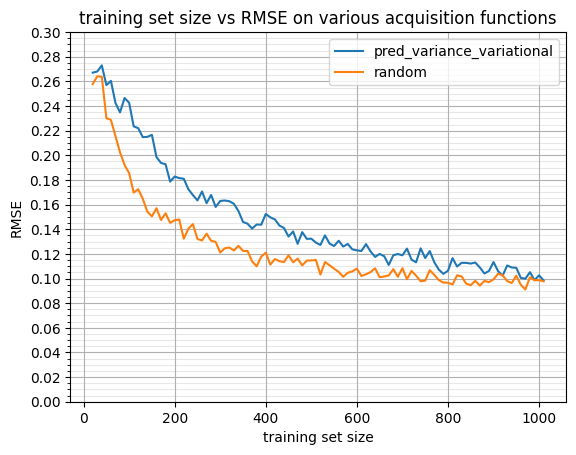

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter
names =  ["pred_variance_variational", "random"]
for i in range(2):
  accs = avg_regression_results[i]
  plt.plot([acc[1] for acc in accs], [acc[0] for acc in accs], label=names[i])


ax = plt.gca()
ax.set_ylim(0.0, 0.3)

ax.yaxis.set_major_locator(MultipleLocator(0.02))
ax.yaxis.set_minor_locator(MultipleLocator(0.005))

ax.grid(True, which="major")
ax.grid(True, which="minor", alpha=0.3)

plt.title("training set size vs RMSE on various acquisition functions")
plt.xlabel("training set size")
plt.ylabel("RMSE")
plt.legend()
plt.show()